In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import PIL
import torch
import torchvision
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import models
from torchvision import transforms
from IPython.display import display
from torch.utils.data import DataLoader # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os,shutil
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/image-localization-dataset/training_images/mushroom_30.jpg
/kaggle/input/image-localization-dataset/training_images/mushroom_11.xml
/kaggle/input/image-localization-dataset/training_images/mushroom_51.jpg
/kaggle/input/image-localization-dataset/training_images/mushroom_38.jpg
/kaggle/input/image-localization-dataset/training_images/cucumber_28.jpg
/kaggle/input/image-localization-dataset/training_images/cucumber_63.xml
/kaggle/input/image-localization-dataset/training_images/eggplant_10.jpg
/kaggle/input/image-localization-dataset/training_images/mushroom_32.jpg
/kaggle/input/image-localization-dataset/training_images/eggplant_51.xml
/kaggle/input/image-localization-dataset/training_images/eggplant_59.jpg
/kaggle/input/image-localization-dataset/training_images/mushroom_21.jpg
/kaggle/input/image-localization-dataset/training_images/mushroom_30.xml
/kaggle/input/image-localization-dataset/training_images/cucumber_43.jpg
/kaggle/input/image-localization-dataset/training_i

In [2]:
destination = "/kaggle/working/dataset"
os.mkdir(destination) if os.path.isdir(destination) == False else print("Done")

for root, dirs, files in os.walk("../input/image-localization-dataset/training_images"):
    for file in files:
        path_file = os.path.join(root,file)
        shutil.copy2(path_file,destination)
        
src_folder = "/kaggle/working/dataset"
dst_images = "/kaggle/working/images"
dst_annotations = "/kaggle/working/annotations"
os.mkdir(dst_images) if os.path.isdir(dst_images) == False else print("Done")
os.mkdir(dst_annotations) if os.path.isdir(dst_annotations) == False else print("Done")

In [3]:
for filename in os.listdir(src_folder):
    if filename.endswith('.xml'): 
        src = os.path.join(src_folder, filename)
        dst = os.path.join(dst_annotations, filename)
        shutil.copyfile(src, dst)
    elif filename.endswith('.jpg'): 
        src = os.path.join(src_folder, filename)
        dst = os.path.join(dst_images, filename)
        shutil.copyfile(src, dst)
        

In [4]:
import xml.etree.ElementTree as et
path = '/kaggle/working/annotations'
height, width, xmin, ymin, xmax, ymax, file_name = [], [], [], [], [], [], []


for filename in os.listdir(path):
    file = os.path.join(path, filename)
    xtree = et.parse(file)
    xroot = xtree.getroot()
    file_name.append(filename)

    for sizes in xroot.findall('object/bndbox'):    
        xmin_iter = sizes.find('xmin').text
        ymin_iter = sizes.find('ymin').text
        xmax_iter = sizes.find('xmax').text
        ymax_iter = sizes.find('ymax').text
        xmin.append(float(xmin_iter))
        ymin.append(float(ymin_iter))
        xmax.append(float(xmax_iter))
        ymax.append(float(ymax_iter))
        
bounding_boxes = pd.DataFrame({"File": file_name, "xmin": xmin, "ymin": ymin, "xmax": xmax, "ymax": ymax})
bounding_boxes.head()

,File,xmin,ymin,xmax,ymax
0,eggplant_43.xml,56.0,35.0,145.0,212.0
1,mushroom_60.xml,72.0,69.0,217.0,202.0
2,eggplant_19.xml,15.0,85.0,197.0,149.0
3,mushroom_23.xml,8.0,5.0,226.0,226.0
4,cucumber_60.xml,55.0,58.0,219.0,201.0


In [5]:
from sklearn.model_selection import train_test_split
len_dataset = len(bounding_boxes)
bounding_boxes["File"] = bounding_boxes["File"].str.replace(".xml", ".jpg")
# train_dataset = bounding_boxes.loc[: len_dataset - 18, "File":"ymax"]
# test_dataset = bounding_boxes.loc[len_dataset - 18 + 1: , "File":"ymax"]
train_dataset, test_dataset = train_test_split(bounding_boxes, test_size=0.1)


In [6]:
display(train_dataset.head())
display(test_dataset.head())

,File,xmin,ymin,xmax,ymax
55,cucumber_35.jpg,4.0,35.0,225.0,196.0
182,eggplant_53.jpg,29.0,36.0,171.0,198.0
9,cucumber_34.jpg,16.0,52.0,210.0,184.0
12,eggplant_59.jpg,8.0,49.0,213.0,214.0
161,eggplant_56.jpg,31.0,67.0,215.0,160.0


,File,xmin,ymin,xmax,ymax
26,eggplant_60.jpg,24.0,75.0,184.0,161.0
131,eggplant_47.jpg,29.0,74.0,186.0,172.0
146,eggplant_61.jpg,24.0,11.0,215.0,212.0
147,eggplant_1.jpg,2.0,5.0,214.0,225.0
124,cucumber_12.jpg,22.0,67.0,218.0,158.0


In [7]:
from torchvision import transforms

transforms_data = transforms.Compose([transforms.Resize((150, 150)), transforms.ToTensor(), 
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225] )])

In [8]:
class CNN_redux(nn.Module):
    def __init__(self, num_classes = 4):
        super(CNN_redux, self).__init__()
        self.features = nn.Sequential(
                    nn.Conv2d(3, 32, kernel_size=7, padding = 0, bias=True), nn.ReLU(),
                    nn.BatchNorm2d(32),
                    nn.MaxPool2d(kernel_size=2, stride=2),
                    
                    
                    nn.Conv2d(32, 64, kernel_size=5, padding = 0, bias=True), nn.ReLU(),
                    nn.BatchNorm2d(64),
                    nn.MaxPool2d(kernel_size=2, stride=2),
            
                    nn.Conv2d(64, 96, kernel_size=5, padding = 0, bias=True), nn.ReLU(),
                    nn.BatchNorm2d(96),
                    nn.MaxPool2d(kernel_size=2, stride=2)
                    )
        
        self.classifier = nn.Sequential(
                            nn.Linear(96 * 15 * 15, 512),
                            nn.ReLU(),
                            nn.Dropout(0.2),
            
                            nn.Linear(512, 256),
                            nn.ReLU(),
                            nn.Dropout(0.2),
            
                            nn.Linear(256, 128),
                            nn.ReLU(),
    
                            nn.Linear(128, 4))

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x,1)
        x = self.classifier(x)
        
        return x

In [9]:
model = CNN_redux()
optimizer = optim.Adam(model.parameters(), lr=0.00001)
epochs = 300

USE_GPU = True
dtype = torch.float32
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('using device:', device)


using device: cuda


In [10]:
model = model.to(device = device)
PATH = "/kaggle/working/best_model.pth"

if os.path.isfile(PATH) == False:
    for epoch in range(epochs):
        model.train()
        print("\nEPOCH = ", epoch + 1)
        iou_acc = 0
        loss_acc = 0
        for item in train_dataset.itertuples():

            img = PIL.Image.open(os.path.join(dst_images, item.File))
            x = transforms_data(img).unsqueeze(0)
            bbox = [item.xmin, item.ymin, item.xmax, item.ymax]
            y_np = np.array(bbox, dtype = np.float32)
            y = torch.tensor(y_np)

            x = x.to(device, dtype = torch.float32)
            y = y.to(device)

            optimizer.zero_grad()

            scores = model.forward(x).squeeze(0)        

    #         print(scores)

            loss_func = nn.MSELoss()
            loss = torch.sqrt(loss_func(scores, y))
            loss.backward()

            optimizer.step()

            loss_acc += loss

            xA = max(int(scores[0].item()), y[0].item())
            yA = max(int(scores[1].item()), y[1].item())
            xB = min(int(scores[2].item()), y[2].item())
            yB = min(int(scores[3].item()), y[3].item())

            intersection = max(0, xB - xA + 1e-8) * max(0, yB - yA + 1e-8)

            rect_1 = (int(scores[2].item()) - int(scores[0].item()) + 1e-8) * (int(scores[3].item()) - int(scores[1].item()) + 1e-8)
            rect_2 = (y[2].item() - y[0].item() + 1e-8) * (y[3].item() - y[1].item() + 1e-8)

            iou = intersection / float(rect_1 + rect_2 - intersection)
            iou_acc += iou

        print("Epoch Loss is {:.4f}.".format(loss_acc / len(train_dataset)))
        print("Epoch IOU is {:.4f}.".format(iou_acc / len(train_dataset)))
    
    torch.save(model, PATH)

else:
    print("Training completed.")



    
 


EPOCH =  1
Epoch Loss is 136.1670.
Epoch IOU is 0.0000.

EPOCH =  2
Epoch Loss is 113.9992.
Epoch IOU is 0.0060.

EPOCH =  3
Epoch Loss is 42.2684.
Epoch IOU is 0.3802.

EPOCH =  4
Epoch Loss is 26.9072.
Epoch IOU is 0.5490.

EPOCH =  5
Epoch Loss is 25.6865.
Epoch IOU is 0.5580.

EPOCH =  6
Epoch Loss is 24.8551.
Epoch IOU is 0.5707.

EPOCH =  7
Epoch Loss is 23.9724.
Epoch IOU is 0.5839.

EPOCH =  8
Epoch Loss is 23.5234.
Epoch IOU is 0.5853.

EPOCH =  9
Epoch Loss is 22.8951.
Epoch IOU is 0.5930.

EPOCH =  10
Epoch Loss is 22.7302.
Epoch IOU is 0.6018.

EPOCH =  11
Epoch Loss is 21.7383.
Epoch IOU is 0.6080.

EPOCH =  12
Epoch Loss is 21.3529.
Epoch IOU is 0.6186.

EPOCH =  13
Epoch Loss is 20.4819.
Epoch IOU is 0.6268.

EPOCH =  14
Epoch Loss is 20.2722.
Epoch IOU is 0.6289.

EPOCH =  15
Epoch Loss is 19.8588.
Epoch IOU is 0.6308.

EPOCH =  16
Epoch Loss is 19.0150.
Epoch IOU is 0.6453.

EPOCH =  17
Epoch Loss is 19.0093.
Epoch IOU is 0.6490.

EPOCH =  18
Epoch Loss is 18.4590.
Ep

/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type CNN_redux. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


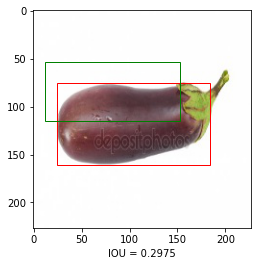

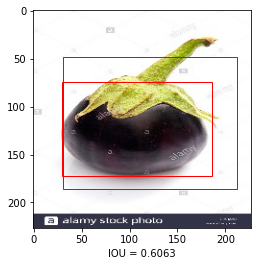

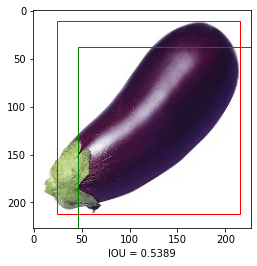

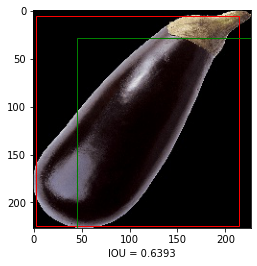

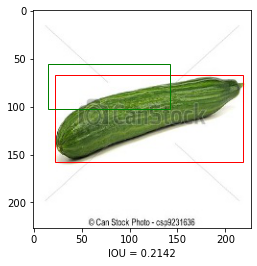

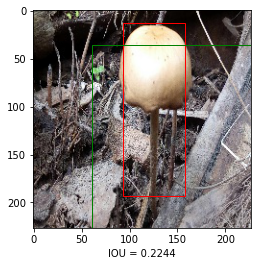

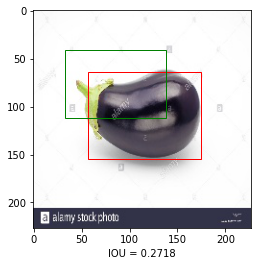

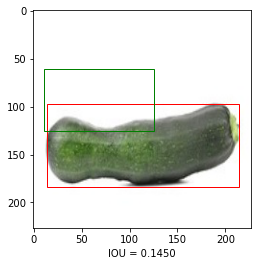

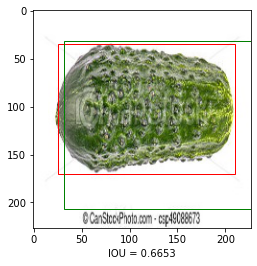

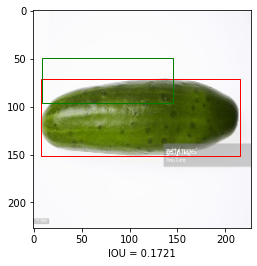

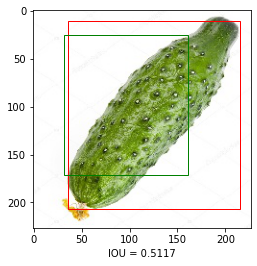

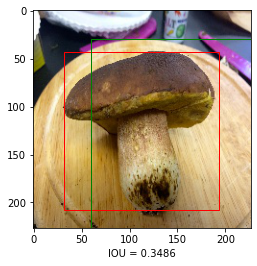

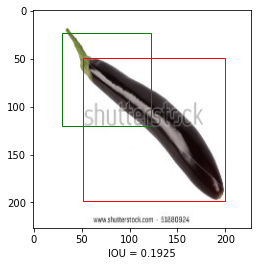

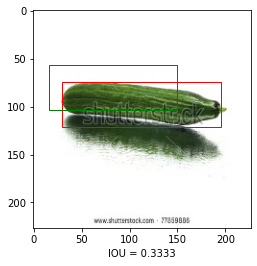

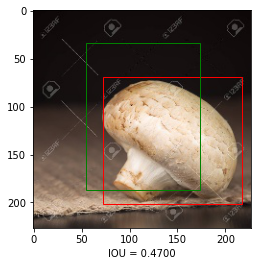

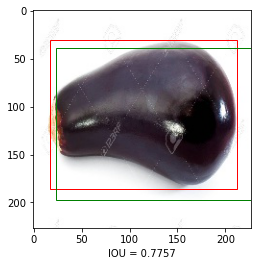

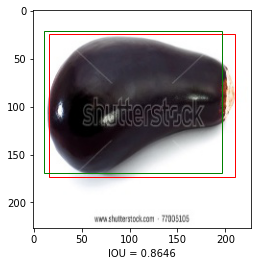

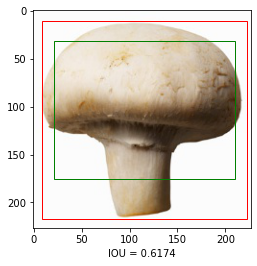

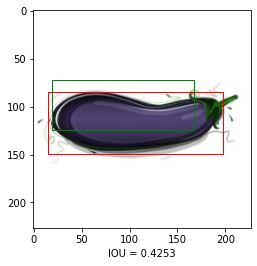

19
Test Loss is 34.3827.
Test IOU is 0.4376.


In [11]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

model.eval()
iou_acc = 0
loss_acc = 0

for item in test_dataset.itertuples(): 
    img = PIL.Image.open(os.path.join(dst_images, item.File))
    x = transforms_data(img).unsqueeze(0)
    bbox = [item.xmin, item.ymin, item.xmax, item.ymax]
    y_np = np.array(bbox, dtype = np.float32)
    y = torch.tensor(y_np)

    x = x.to(device, dtype = torch.float32)
    y = y.to(device)

    scores = model.forward(x).squeeze(0)        

    loss_func = nn.MSELoss()
    loss = torch.sqrt(loss_func(scores, y))

    loss_acc += loss

    xA = max(int(scores[0].item()), y[0].item())
    yA = max(int(scores[1].item()), y[1].item())
    xB = min(int(scores[2].item()), y[2].item())
    yB = min(int(scores[3].item()), y[3].item())

    intersection = max(0, xB - xA + 1e-8) * max(0, yB - yA + 1e-8)

    rect_1 = (int(scores[2].item()) - int(scores[0].item()) + 1e-8) * (int(scores[3].item()) - int(scores[1].item()) + 1e-8)
    rect_2 = (y[2].item() - y[0].item() + 1e-8) * (y[3].item() - y[1].item() + 1e-8)

    rect_gt = Rectangle((y[0].item(),y[1].item()),y[2].item() - y[0].item(), y[3].item() - y[1].item(), 
                                linewidth=1,edgecolor='r',facecolor='none')
    rect_pred = Rectangle((int(scores[0].item()),int(scores[1].item())),int(scores[2].item()) - int(scores[0].item()),
                                  int(scores[3].item()) - int(scores[1].item()), linewidth=1,edgecolor='g',facecolor='none')
    
    iou = intersection / float(rect_1 + rect_2 - intersection)
    iou_acc += iou
    
    plt.imshow(img)
    ax = plt.gca()
    ax.add_patch(rect_gt)
    ax.add_patch(rect_pred)
    plt.xlabel("IOU = {:.4f}".format(iou))
    plt.show()
    
    
    

print(len(test_dataset))
print("Test Loss is {:.4f}.".format(loss_acc / len(test_dataset)))
print("Test IOU is {:.4f}.".format(iou_acc / len(test_dataset)))
     